In [1]:
import awkward as ak
import numpy as np
from coffea.analysis_tools import Weights, PackedSelection
import correctionlib
import hist
from coffea import processor
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from constructors.filesets import filesets
from loadmodule import loadModule
#ObjectSelector = loadModule("constructors/selections/object_selector.py")
#ObjectCorrector = loadModule("constructors/corrections/object_corrector.py")
#CrystallBall = loadModule("constructors/corrections/crystall_ball.py")
from loadmodule import loadFunction
from constructors.corrections.crystall_ball import apply_rochester_corrections_run2
test_fileset = getattr(filesets,'test_fileset')
events = NanoEventsFactory.from_root(
    test_fileset["DYJets"]["files"],
    schemaclass=NanoAODSchema,
    entry_stop=10_000,
).events();

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


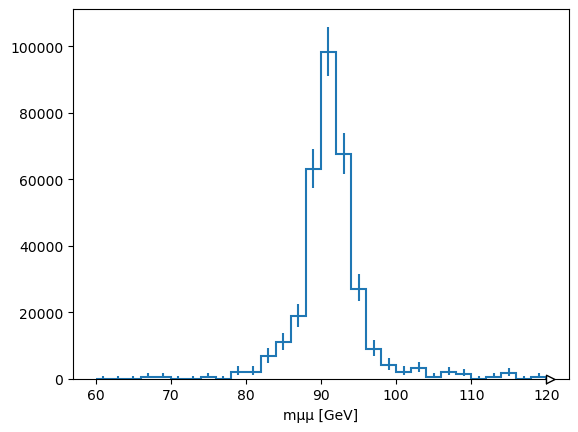

In [2]:
################## object correction
apply_rochester_corrections_run2(events,"2018")
################## object selection
muons = events.Muon

good_muons = (
    (muons.pt > 35)
    & (abs(muons.eta) < 2.4)
    & muons.tightId
    & (muons.pfRelIso03_all < 0.15)
)
muons = muons[good_muons]

dimuons = ak.combinations(muons, 2, fields=["lead","trail"])
dimuons = dimuons[dimuons.lead.charge != dimuons.trail.charge]
mass = ak.firsts((dimuons.lead + dimuons.trail).mass)
mass = ak.nan_to_num(mass, nan=0)

################## event selection
sumw_before = ak.sum(events.genWeight)
selections = PackedSelection()
selections.add("IsoMu24", events.HLT.IsoMu24)
selections.add("at_least_one_dimuons", ak.num(dimuons)>0)
region_mask = selections.all("IsoMu24", "at_least_one_dimuons")
pruned_ev = events[region_mask]
mass = mass[region_mask]

muons = pruned_ev.Muon

################## event correction
cset_path = "constructors/corrections/sets/muon_Z.json.gz"
cname = "NUM_IsoMu24_DEN_CutBasedIdTight_and_PFIsoTight"
cset = correctionlib.CorrectionSet.from_file(cset_path)
corr = cset[cname]
m, n = ak.flatten(muons), ak.num(muons)
objects_pt_mask = m.pt > 26.01
objects_eta_mask = np.abs(m.eta) < 2.39
objects_mask = objects_pt_mask & objects_eta_mask
in_limit_objects = m.mask[objects_mask]
objects_pt = ak.fill_none(in_limit_objects.pt, 26.01)
objects_eta = ak.fill_none(np.abs(in_limit_objects.eta), 0.)
sf = corr.evaluate(objects_eta, objects_pt, "nominal")
sf = ak.where(objects_mask, sf, ak.ones_like(sf))
sf = ak.unflatten(sf, n)
sf = ak.prod(sf, axis=1)
weights_container = Weights(size=len(pruned_ev), storeIndividual=True)
weights_container.add("sf", sf)
region_weights = weights_container.weight()

#########filling and normalize histograms
weights = ak.broadcast_arrays(region_weights, mass)[0]
sumw_after = ak.sum(region_weights)
dimuon_mass_hist = hist.Hist.new.Reg(30, 60, 120, name="mass", label="mμμ [GeV]").Weight()
dimuon_mass_hist.fill(
    mass=ak.to_numpy(mass),
    weight=ak.to_numpy(weights),
)

L = 41477.88
xs = 3503.7

dimuon_mass_hist = dimuon_mass_hist * L*xs*sumw_after/sumw_before


out = {
    "mass": dimuon_mass_hist,
}
out["mass"].plot1d();

In [27]:
mass

<Array [None, None, None, None, ..., None, None, None] type='10000 * ?float32'>